##  Income earning differences among different generation 

[Work Experience and Income data from Data Source from U.S. Census Bureau](https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.html)

Note on Data Sources
1. Work experience information is given for individuals 15 years and older. 
2. All data and employment information refer to the prior year, while demographic information is current to the time of the study.

### Questions 

- **How do generations vary financially?**
- **Which industries to different generations work in?**
- **What are the average hours worked per week for each generation?**

### Methodology

In order to answer these questions, we first found the relevant dataset from census.gov, and isolated the columns that we needed:

| Column   | Description                              |
| ---------| -----------------------------------------|
| A_HGA    | educational attainment - nominal         |
| AGE1     | age of individual, by group - ordinal    |
| PEARNVAL | total earnings of the individual - ratio |
| A_MJIND  | major industry code                      |


For each column

- we checked for the correct data type
- we examine outliers
- we cleansed the data by removing outliers and incorrect values

We review what we have so far to see if we need to create new features, or reduce existing categories.

Using the cleaned columns and generation measure, we answered our questions.

### Table of Content

* [Section 1: Data Exploration and Data Cleansing](#section_1)
    * [Section 1.1: Using histogram to spot age outliers](#section_1_1)
    * [Section 1.2: Review Education Attainment distribution](#section_1_2)
    * [Section 1.3: Using Boxplot and percentil to examine Total Earnings Column](#section_1_3)
* [Section 2: Feature Engineering](#section_2)
    * [Section 2.1: Bucketing Age to Age Group to reduce Categories](#section_2_1)
* [Section 3: Analysis](#section_3)
    * [Section 3.1: Earning Analysis](#section_3_1)
    * [Section 3.2: Earning Observation](#section_3_2)
    * [Section 3.3: Industry spread per generation](#section_3_3)
    * [Section 3.4: Top 10 Industries](#section_3_4)
    * [Section 3.5: Top 10 Industries (Boomers)](#section_3_5)
    * [Section 3.6: Top 10 Industries (GenX)](#section_3_6)
    * [Section 3.7: Top 10 Industries (Millenials)](#section_3_7)
    * [Sectiion 3.8 Industry Analysis Observation](#section_3_8)
* [Section 4: Takeaway](#section_4)

#### Data Sources

1. 2021 Annual Social and Economic Supplement (ASEC)

The first data source comes from census.gov


- For the sake of this project, we are just pulling from the individual (person) record type.



In [1]:
#import pandas
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import the pppub21 dataset as 'person'
person = pd.read_csv("pppub21.csv")

<section id="section_1"></section>

## Section 1 : Data Exploration  and Data Cleansing
    

####  Dimensions that are related to our questions

<section id="section_1_1"></section>

### Section 1.1 : Using histogram to spot outliers


#### Basic matrix of AGE

In [3]:
person['AGE1'].describe()

count    163543.000000
mean          7.766392
std           5.560080
min           0.000000
25%           2.000000
50%           8.000000
75%          12.000000
max          17.000000
Name: AGE1, dtype: float64

#### Histogram of Age

<AxesSubplot:title={'center':'distribution of AGE1 column'}>

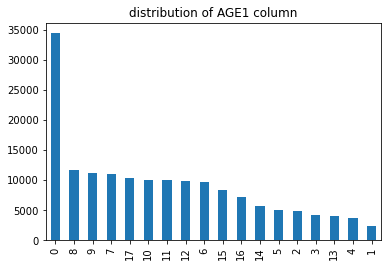

In [4]:
#create histogram 
age_distribution = person['AGE1'].value_counts()
age_distribution.plot.bar(title="distribution of AGE1 column")

**It looks like there are a large number of columns that don't have an age attached with them. Our primary goal here is to evaluate how different generations vary in multiple finanical aspects, so let's create a new DF without columns that have 0 in the AGE1 column.**

### Observation

There were 35000 records with ago = 0. Since without age we can't do any generation analysis, 
let's drop them so they won't impact our study.

#### Drop those where AGE = 0

In [5]:
#Create new DF
person1 = person[person["AGE1"] > 0]

<section id="section_1_2"></section>

### Section 1.2 : Review Educational Attainment Distribution

In [6]:
#run .describe() to see if there are any values that should not be there
person1['A_HGA'].describe()

count    129110.000000
mean         40.326295
std           2.858353
min          31.000000
25%          39.000000
50%          40.000000
75%          43.000000
max          46.000000
Name: A_HGA, dtype: float64

#### Educational Attainment Column


- Normal Value for the highest education received by the individual
- Range : 31 to 46


It looks like there are no values with 0 in this changed dataframe, which may indicate that every 0 value in the AGE1 category may have been under 15 years old. this works for us because we don't have financial information for them. Everything else looks okay so far, but let's plot a frequency histogram of the information.

<AxesSubplot:title={'center':'educational attainment'}>

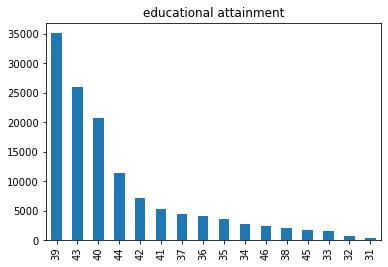

In [7]:
edu_distribution = person1['A_HGA'].value_counts()
edu_distribution.plot.bar(title="educational attainment")

<section id="section_1_3"></section>

### Section 1.3 : Using Boxplot and percentil to examine Total Earnings Column

- Total Earning : total amount that an individual has earned in the last year.

#### Basic Metrics for Total Earnings

In [8]:
person1['PEARNVAL'].describe()

count    1.291100e+05
mean     3.627954e+04
std      6.832647e+04
min     -9.999000e+03
25%      0.000000e+00
50%      1.700000e+04
75%      5.000000e+04
max      2.899899e+06
Name: PEARNVAL, dtype: float64

It does look like we have negative values. Theoretically, it is possible that an individual can earn negative values. 
Let's plot out the values in a box-and-whisker plot to get a visual representation of the data spread.

<AxesSubplot:>

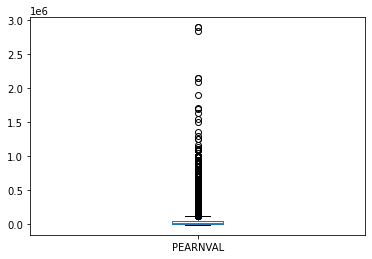

In [9]:
person1['PEARNVAL'].plot.box()

#### Luckily, there don't seem to be too many negative values. Let's find out how many there are in proportion to positive values.

In [10]:
positive_incomes = person1[person1['PEARNVAL'] >= 0]
print(type(positive_incomes))
print('positive earnings:',positive_incomes['PEARNVAL'].size)

negative_incomes = person1[person1['PEARNVAL'] < 0]
print('negative earnings:',negative_incomes['PEARNVAL'].size)


<class 'pandas.core.frame.DataFrame'>
positive earnings: 128853
negative earnings: 257


Sometimes, -999 or -99 is used to indicate a null value, depending on who codes the information. As the max value is -9999, let's see how many instances of -9999 are:

In [11]:
#count number of items in negative_incomes['PEARNVAL']
sum(negative_incomes['PEARNVAL'] == -9999)

145

As the -9999 values make up the majority of the negative numbers, I'm going to make the assumption that these numbers are just missing financial information, and am going to remove it from person1.

In [12]:
#remove all values that equal to -9999
person1 = person1[person1["PEARNVAL"]> 0]


In [13]:
person1['PEARNVAL'].describe()

count    8.115100e+04
mean     5.774256e+04
std      7.865875e+04
min      1.000000e+00
25%      2.000000e+04
50%      4.000000e+04
75%      7.000000e+04
max      2.899899e+06
Name: PEARNVAL, dtype: float64



code: ERN_SRCE

Earn Source is the source of earnings from the longest job - it categorizes the most significant type of earning for each individual.

- 0: not asked
- 1: wage and salary
- 2: self employment
- 3: farm self employment
- 4: without pay

In [14]:
#.describe() for earn source
person1["ERN_SRCE"].describe()

count    81151.000000
mean         1.061145
std          0.256105
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: ERN_SRCE, dtype: float64

<section id="section_2"></section>

## Section 2.0 : Feature Engineering

A large proportion of the respondents were not asked this question, so we may omit it from our analysis.

<section id="section_2_1"></section>

### Section 2.1: Bucketing Age to Age Group to reduce Categories 


we've cleared the data, and are ready to conduct our analysis.

Our first step in our analysis is to determine how we would like to split our age groups apart.

- Gen z: 9-24
- Millenials: 25-40
- Gen X: 41-56
- Boomers: 57-75
- Silent Gen: 76-93

As we only have information that starts from 15 years and up, we'll start from millenials. Let's split the AGE1 into three groups:

- Millenials: [6,7,8]
- Gen X: [9,10,11]
- Boomers: [12,13,14,15,16]

Now, we'll write a function that assigns labels to the columns based on their AGE1 ranking


In [15]:
#write function to assign labels depending on value
def set_age_group(x):
    if x >= 6 and x <= 8:
        return 'Millenials'
    elif x >= 9 and x <= 11:
        return 'GenX'
    elif x >= 12 and x <= 16:
        return 'Boomers'
    else:
        return '0'

In [16]:
#create new Series 'generation', apply it along the axis of a series 
person1['generation']=person1['AGE1'].apply(lambda x:set_age_group(x))

In [17]:
#remove all columns that have value '0' in 'generations' value
person1 = person1[person1['generation'] != '0']

<section id="section_3"></section>

## Section 3.0: Analysis

<section id="section_3_1"></section>

### Section 3.1:  Mean Earnings by Generation

Now that we have the data separated into generations, let's examine the mean earnings by generation.

In [18]:

#create means for each value, grouping by 'generation' column
earning_mean = person1.groupby('generation')['PEARNVAL'].mean()

earning_mean

generation
Boomers       63207.904470
GenX          71496.155789
Millenials    54919.948285
Name: PEARNVAL, dtype: float64

<AxesSubplot:title={'center':'Mean Earnings For 2020 By Generation'}, xlabel='generation'>

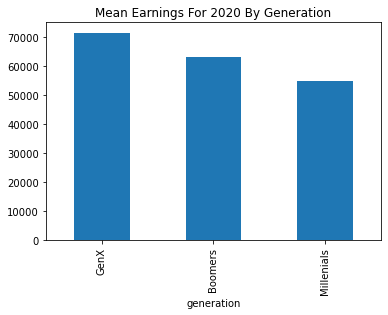

In [19]:
#plot bar chart of earning_mean, sorting the values by descending order
earning_mean.sort_values(ascending=False).plot.bar(title="Mean Earnings For 2020 By Generation")

In [20]:
earning_mean.sort_values(ascending=False)

generation
GenX          71496.155789
Boomers       63207.904470
Millenials    54919.948285
Name: PEARNVAL, dtype: float64

<section id="section_3_2"></section>

### Section 3.2: Mean Earning Observation

Gen X has the highest average earnings per year, while boomers are in the middle, with millenials trailing behind. To make sure that our data isn't heavily skewed in any direction, let's print out the number of values for each generation.

In [21]:
person1['generation'].value_counts()

Millenials    26859
GenX          25695
Boomers       17942
Name: generation, dtype: int64


There seem to be significantly less boomers than millenials and genx individuals. The sampling was done randomly to get a representative sample of ages and populations, and I know that the number of boomers dropped significantly after I filtered the dataframe earnings to greater than 0, so it is reasonable to conclude that **there is a dip in the number of boomers because many have reported their earnings as 0.** 

The drop in values can be most likely attributed to retirement, or boomers logging in their earnings as 0.

<section id="section_3_3"></section_3_3>
             
### Section 3.3: Industry spread per generation

Next, let's look at the different industries that each generation works in. Does the industry spread vary for each generation?

Because there is already a row of 'generation', let's aggregrate 'A_MJIND' and name it industry_by_gen.

First, let's remap the values in A_MJIND to its actual industries:


In [22]:
#create dict for industry values to map
industry_values = {0:'niu',1:"Agriculture, forestry, fishing, and hunting",2:"Mining",3:"Construction",
                   4:"Manufacturing",5:"Wholesale and retail trade",6:"Transportation and utilities",
                  7:"Information",8:"Financial activities",9:"Professional and business services",
                   10:"Educational and health services",11:"Leisure and hospitality",
                  12:"Other services",13:"Public administration",14:"Armed Forces"}

In [23]:
#map onto person1['A_MJIND']
person1['A_MJIND'] = person1["A_MJIND"].map(industry_values)
#read into head to verify change
person1["A_MJIND"].head()

1                       Construction
3    Educational and health services
4       Transportation and utilities
5         Wholesale and retail trade
9            Leisure and hospitality
Name: A_MJIND, dtype: object

In [24]:
cols=person1.columns.to_list()
[c for c in cols if c.find('gen')>-1]

['generation']

In [25]:
#create grouped series 'industry_by_gen', grouping by generation, agg by industry counts
industry_by_gen = person1.groupby('generation')['A_MJIND'].value_counts()
industry_by_gen.sort_values(ascending=False)

# industry_by_gen

generation  A_MJIND                                    
GenX        Educational and health services                6274
Millenials  Educational and health services                6049
Boomers     Educational and health services                3883
Millenials  Professional and business services             3319
            Wholesale and retail trade                     3055
GenX        Professional and business services             2959
            Wholesale and retail trade                     2557
            Manufacturing                                  2501
Millenials  Manufacturing                                  2373
GenX        Construction                                   2037
Millenials  Construction                                   2019
Boomers     Wholesale and retail trade                     1994
Millenials  Leisure and hospitality                        1935
Boomers     Professional and business services             1917
GenX        Financial activities                

We have sorted individuals into their respective generations and categorized their industries by group. Let's look at a visual representation for each group.

<section id="section_3_4"></section>

### Section 3.4: Top 10 Industries overall

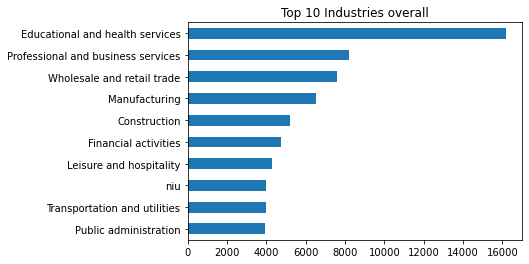

In [26]:
#top 10 industries in general
industry_temp = person1['A_MJIND'].value_counts().nlargest(n=10).sort_values(ascending=True)
industry_temp.plot.barh(title="Top 10 Industries overall");

<section id="section_3_5"></section>

### Section 3.5: Top 10 Industries (Boomers)

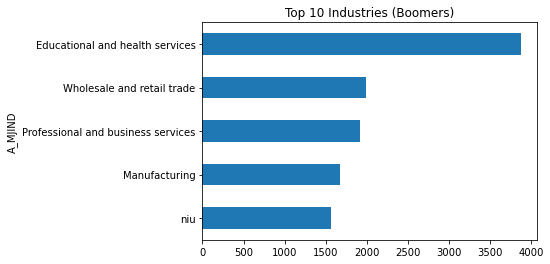

In [27]:
industry_by_gen['Boomers'].nlargest(n=5).sort_values(ascending=True).plot.barh(title="Top 10 Industries (Boomers)");

<section id="section_3_6"></section>

### Section 3.6: Top 10 Industries (GenX)

<AxesSubplot:ylabel='A_MJIND'>

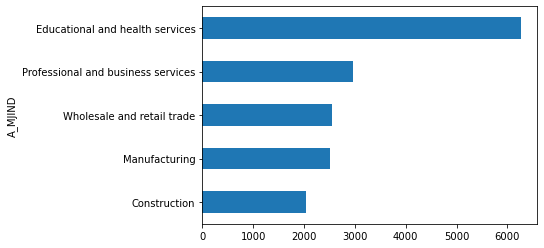

In [28]:
industry_by_gen['GenX'].nlargest(n=5).sort_values(ascending=True).plot.barh()

<section id="section_3_7"></section>

### Section 3.7: Top 10 Industries (Millenials)

<AxesSubplot:title={'center':'Top 10 Industries (Millenials)'}, ylabel='A_MJIND'>

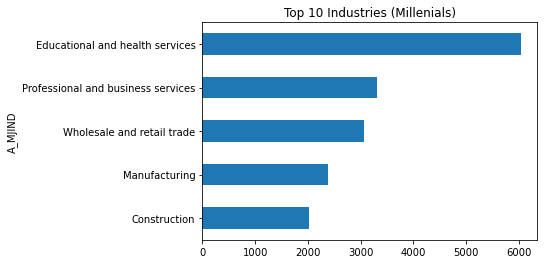

In [35]:
industry_by_gen['Millenials'].nlargest(n=5).sort_values(ascending=True).plot.barh(title="Top 10 Industries (Millenials)")

<section id="section_3_8"></section>

### Sectiion 3.8 Industry Analysis Observation

**Overall, it doesn't look like a large difference between the industries between generations, aside from some minor variances. There doesn't seem to be much here to explain the significant earning disparity between generations.**

## Average hours worked by generation

column: HRSWK

let's find the average number of hours worked/week for each generation

In [30]:
#create grouped series
hours_worked_by_gen = person1.groupby('generation')['HRSWK'].mean()

In [31]:
hours_worked_by_gen

generation
Boomers       38.502341
GenX          40.692002
Millenials    39.804386
Name: HRSWK, dtype: float64

<AxesSubplot:ylabel='generation'>

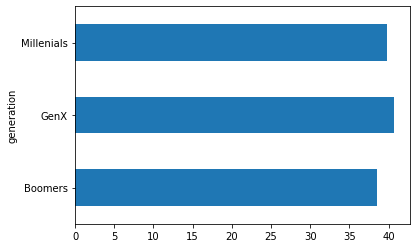

In [32]:
hours_worked_by_gen.plot.barh()

<section id="section_4"></section>

### Section 4: Takeaways



#### Generation earnings

   On average, **genX individuals earned 8k more than boomers, and boomers earned 9k more than millenials**

    GenX          71496.155789
    Boomers       63207.904470
    Millenials    54919.948285


#### Industry spread for each generation

For each generation, the **majority of individuals worked in the educational and health services industries.** 
When each generation was ranked by top 5 industries, these 5 industries were consistently at the top of the list:
    
    - educational and health services
    - professional and business services
    - wholesale and retail trade
    - manufacturing
    - construction
    
#### Average hours worked per week for each generation

the spread seemed relatively close, **there didn't seem to be any significant difference in hours worked overall**
    
    GenX          40.692002
    Millenials    39.804386
    Boomers       38.502341
    

*A significant amount of the boomers had retired, and they listed their earnings as 0. We removed their information because we only wanted to look at individuals who were earning money.
